Osnabrück University - Machine Learning (Summer Term 2016) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 04: Clustering

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, May 8, 2016**. If you need help (and Google and other resources were not enough), feel free to contact your groups designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

In the following tasks we will be relying on numpy. Using the following import we expect it to be in global scope as `np`. Therefore we can, after executing the following cell, use stuff like `np.array` and `np.sqrt`. Check out the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html) and especially search it using e.g. [Google Site Search](https://www.google.de/search?q=array+site%3Adocs.scipy.org%2Fdoc%2Fnumpy)! You can also try `np.lookfor('keyword search docstrings')` to get help.

In [140]:
import numpy as np

In [141]:
np.lookfor('get array diagonal')

Search results for 'get array diagonal'
---------------------------------------
numpy.fill_diagonal
    Fill the main diagonal of the given array of any dimensionality.
numpy.mask_indices
    Return the indices to access (n, n) arrays, given a masking function.


## Assignment 1: Distance Measures [4 Points]

This exercise is focused on implementing some distance functions that later on help with the clustering. They should all use the euclidean distance as a measurement. The first function is closely related to the MATLAB pdist2 function. This is the summary from the [documentation](http://de.mathworks.com/help/stats/pdist2.html):

*D = pdist2(X,Y) returns a matrix D containing the Euclidean distances between each pair of observations in the mx-by-n data matrix X and my-by-n data matrix Y. Rows of X and Y correspond to observations, columns correspond to variables. D is an mx-by-my matrix, with the (i,j) entry equal to distance between observation i in X and observation j in Y. The (i,j) entry will be NaN if observation i in X or observation j in Y contain NaNs.*

In [142]:
def pdist2(X, Y):
    """
    Pairwise distance between all points of two datasets.
    X and Y are expected to be numpy arrays of size mx-by-n and my-by-n, respectivley. 
    n and m being the amount of observations in the first dimension of each set.
    """
    return np.array([[np.linalg.norm(x-y) for y in Y ] for x in X ])


X = np.array([[1,2,3],
              [4,5,6],
              [7,8,9],
              [10,11,12]])
Y = np.array([[13,14,15], [16,17,18], [19,20,21]])
N = np.array([[1,2,3], [float('NaN'),1,0]])


assert pdist2(X, Y).shape == (4, 3), "Shape is wrong: {}".format(pdist2(X, Y).shape)
assert round(pdist2(X, Y)[3,0], 3) == 5.196, "[10,11,12] and [13,14,15] is wrong: {}".format(pdist2(X, Y)[3,0])
assert round(np.mean(pdist2(X, Y)), 3) == 18.187, "Mean distance is wrong: {}".format(np.mean(pdist2(X, Y)))
assert np.isnan(pdist2(X, N)[0,1]), "Should be NaN: {}".format(pdist2(X, N)[0,1])

del X, Y, N

Now implement the $d_{mean}$ and $d_{centroid}$ distance from the lecture. Each function expects two clusters each represented by a 2-dimensional numpy array, where the number of columns $n$ reflects the dimensionality of the data space and has to agree for both clusters, while the number of rows $mx$ and $my$ can vary from cluster to cluster. The return value is the respective distance.

In [149]:
def d_mean(X, Y):
    """
    Mean distance between points of two clusters.
    X and Y are expected to be numpy arrays.
    """
    return np.mean(pdist2(X,Y))


X = np.array([[1,2,3], [4,5,6], [7,8,9]])
Y = np.array([[13,14,15], [16,17,18], [19,20,21], [5,45,1], [1,12,7]])

assert round(d_mean(X,Y), 3) == 22.297, "Result is not correct: {}".format(d_mean(X, Y))
assert d_mean(X, Y) == d_mean(Y, X), "X,Y is not equal to Y,X: {} != {}".format(d_mean(X, Y), d_mean(Y, X))

del X, Y

In [150]:
def d_centroid(X, Y):
    """
    Distance between the centroids of two clusters.
    X and Y are expected to be numpy arrays.
    """
    return np.linalg.norm(np.mean(X,axis=0) - np.mean(Y,axis=0))


X = np.array([[1,2,3], [4,5,6], [7,8,9]])
Y = np.array([[13,14,15], [16,17,18], [19,20,21]])
Z = np.array([[-2,0], [-1,100]])
W = np.array([[2,0], [1,100], [1,-100], [1,-20]])

assert round(d_centroid(X, Y), 3) == 20.785, "Result is not correct: {}".format(d_centroid(X, Y))
assert round(d_centroid(Z, W), 3) == 55.069, "Result is not correct: {}".format(d_centroid(Z, W))
assert d_centroid(X, Y) == d_centroid(Y, X), "X,Y is not equal to Y,X: {} != {}".format(d_centroid(X, Y), d_centroid(Y, X)) 

del X, Y, Z, W

## Assignment 2: Hierarchical Clustering [2 Points]

In the following you find implementations for single- and complete-linkage clustering. *This implementation relies on the distance functions you wrote in Assignment 1 (if you get stuck on the first exercise write an email to the tutors and we will help you along).* Take a look at the code (this might also help if you get stuck on assignment 3) and answer the question posted below. You may of course change parameters and try it out on different datasets (`points.txt` & `clusterData.txt` are provided).

Note that for performance reasons the code differs from the lecture's pseudocode (ML-05 Slide 8), but in general it does the same.

In [145]:
def linkage(data, k=5, complete=False):
    """
    Runs single or complete linkage clustering.
    """
    # Initially all points are their own cluster.
    labels = np.arange(len(data))

    # Calculate distance between all points.
    # Also removing half of the matrix because 
    # its symmetrical along the diagonal.
    dst = np.tril(pdist2(data, data))

    while len(set(labels)) > k:
        # Get the lowest distance of two points which
        # do not have the same label.
        r,c = np.where(dst==np.min(dst[dst>0]))
        
        # Ignore the case when there are multiple with
        # equally smallest distance.
        r = r[0]
        c = c[0]

        # The two points are now in the same cluster,
        # so they have a distance of 0 now.
        dst[r,c] = 0

        # Make the two clusters have the same label.
        labels[labels==labels[r]] = labels[c]

        # Check if we want to do complete linkage clustering.
        if complete:
            # Update the distances of the points which are not in the same cluster.
            for i in np.nonzero(dst[r,:]>0)[0]:
                dst[r,i] = np.max(pdist2(data[i,:], data[labels==labels[r],:]))

            # The distances to c are now the same as to r, so we can just
            # set them to zero - would be duplicates otherwise.
            dst[c,c+1:] = 0

    return labels

<IPython.core.display.Javascript object>


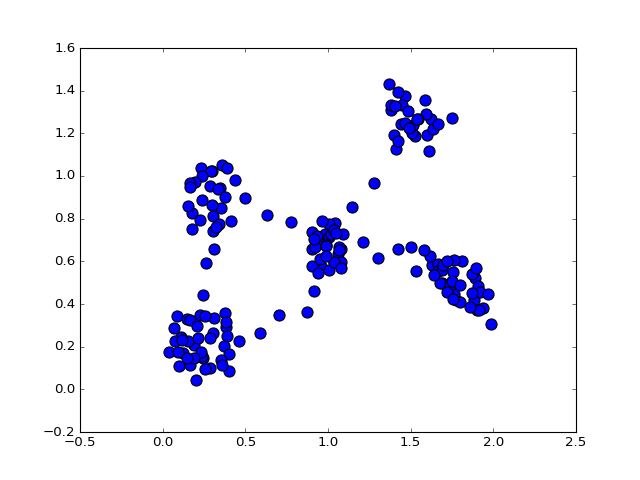

<IPython.core.display.Javascript object>


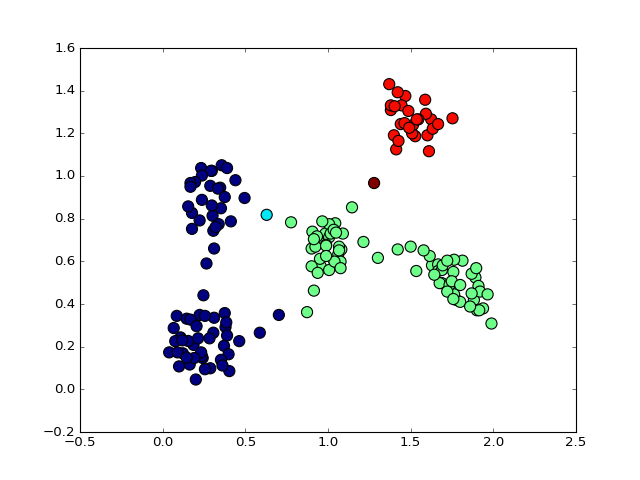

<IPython.core.display.Javascript object>


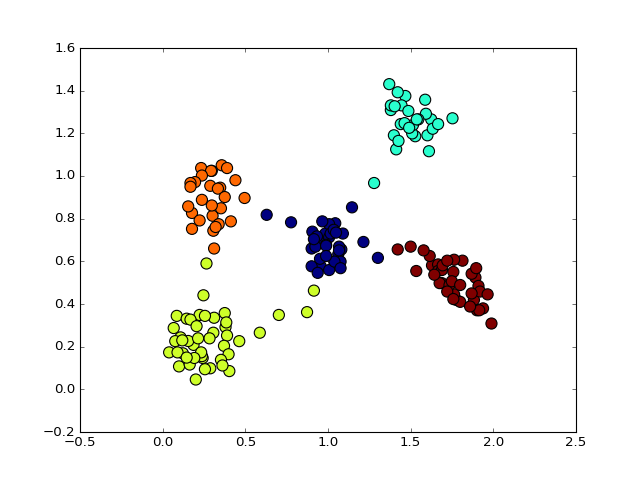

In [146]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# Read the data.
data = np.loadtxt('points.txt')

# Show unprocessed data set.
fig_cluster = plt.figure('Unprocessed Cluster Data')
plt.scatter(data[:,0], data[:,1], s=100)
fig_cluster.canvas.draw()

# Apply Single Linkage Clustering
labels = linkage(data, k=5, complete=False)
fig_single = plt.figure('Single-linkage Clustering with k=5')
plt.scatter(data[:,0], data[:,1], c=labels, s=100)
fig_single.canvas.draw()

# Apply Complete Linkage Clusteringc
labels = linkage(data, k=5, complete=True)
fig_complete = plt.figure('Complete-linkage Clustering with k=5')
plt.scatter(data[:,0], data[:,1], c=labels, s=100)
fig_complete.canvas.draw()

What is the difference between single- and complete-linkage clustering and which is the better solution given the dataset?

## Assignment 3: k-means Clustering [8 Points]

Implement k-means clustering. Plot the results for $k = 7$ and $k = 3$ in colorful scatter plots.

How could one handle situations when one or more clusters end up containing 0 elements?

In [147]:
def kmeans(data, k = 3):
    """
    Applies kmeans clustering to the data using k initial clusters.
    data is expected to be a numpy array of size n*2, 
    n being the amount of observations in the data. 
    
    This function returns the centroids as an np.array of x and y coordinates,
    such that one can access centroids[:,0] for all x values and centroids[:,1]
    for all y values respectively.
    It also returns the labels which are just an np.array of n values corresponding
    to the cluster each data point belongs to (e.g. [1,1,3,5,5,5,...])
    """
    #init random labels
    labels    = np.random.randint(0, k, len(data),dtype='int')
    #init random centroid positions
    centroids = np.random.random([k,len(data[0])])*np.max(data)
    #init centroid-movement as +inf
    eps = np.float('inf')

    while(eps > 0.05):
        #get current positions
        old_pos = centroids*1 
        #get distance matrix of data and centroids
        dist    = pdist2(centroids,data)
        #assign new labels by minimal distance
        labels  = np.argmin(dist,axis=0)
        #get new centroid positions by mean position of assigned datapoints
        for j,d in enumerate(labels):
            centroids[d] = np.mean(data[labels==d], axis=0)
        #get maximal movement of centroids
        eps     = np.max(np.linalg.norm(old_pos-centroids,axis=1)**2)
    
    return (labels.T, centroids)

<IPython.core.display.Javascript object>


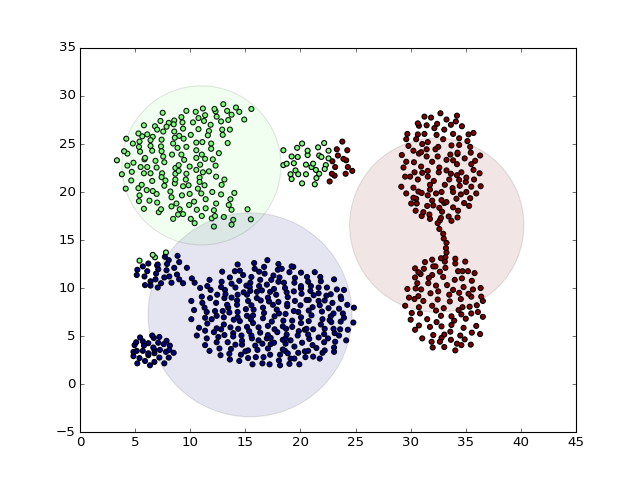

<IPython.core.display.Javascript object>


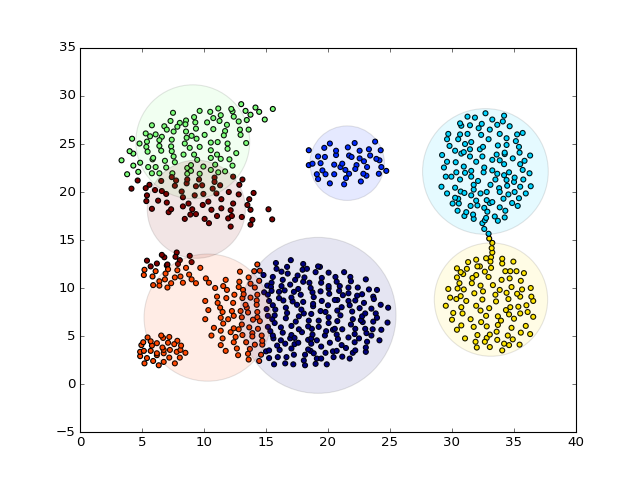

In [152]:
data = np.loadtxt('clusterData.txt')

for k in [3, 7]:
    labels, centroids = kmeans(data, k)
    kmeans_fig = plt.figure('k-means with k={}'.format(k))
    plt.scatter(data[:,0], data[:,1], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], 
                c=list(set(labels)), alpha=.1, marker='o',
                s=np.array([len(labels[labels==label]) for label in set(labels)])*100)
    kmeans_fig.canvas.draw()

## Assignment 4: Soft Clustering with Gaussian Mixture [6 Points]

In this assignment you will calculate the update rules for a Gaussian Mixture model required for the M-step of the EM algorithm. The Gaussian Mixture model can be used for soft clustering since it allows us to express varying degrees of certainty about the membership of individual samples. It is one of the most widely used models since Gaussian distributions generally have the property of fitting all different kinds of data reasonably well.

A mixture model with $K$ components is in general of the form:

$$ p(\mathbf{x}|\mathbf{\theta}) = \sum_{k=1}^K\pi_kp_k(\mathbf{x}|\mathbf{\theta}_k)$$
where $\sum_{k=1}^K\pi_k = 1$.

This means that the probability of observing a dataset $\mathbf{x}$ given the parameter vector $\mathbf{\theta}$ can be expressed as the sum of $K$ individual distributions $p_k$ with parameters $\mathbf{\theta}_k \subseteq {\theta}$ which are weighted by respective class probabilities $\pi_k$. The probability for individual data $x_i \in \textbf{x}$ is calculated correspondingly (note however, that of course the values for individual data differs from the overall probability). 

We can now choose distributions for $p_k$ and $\pi_k$ and we get a whole collection full of different possible models, each of which has its own advantages and disadvantages (you can check <a href='https://en.wikipedia.org/wiki/Mixture_model'>Wikipedia</a> if you want an overview). The easiest case is where our mixing distributions are normally distributed, $p_k \sim \mathcal{N}(\mu_k,\sigma_k)$, and our latent class probabilities have a discrete distribution where we only have $\pi_k \in [0,1]$ and the constraint $\sum_k\pi_k=1$.

If we were to randomly pick values for the parameter vector $\theta$ then we would now have a generative model that can produce naturally clustered data for us, we would just have to sample $\hat{x} \sim p(\mathbf{x}|\mathbf{\theta})$. However, we want to go into the opposite direction and figure out what the distribution of the labels given the data is. This can be calculated easily by Bayes' Theorem for each model $k$, where the (latent) probability for choosing model $k$ is $p(k|\mathbf{\theta}_k) = \pi_k$:

$$p(k|\mathbf{x},\mathbf{\theta})=\frac{p(k|\mathbf{\theta}_k)p(\mathbf{x}|k,\mathbf{\theta}_k)}{\sum_{k'=1}^Kp(k'|\mathbf{\theta}_{k'})p(\mathbf{x}|k',\mathbf{\theta}_{k'})} = \frac{\pi_kp_k(\mathbf{x}|\mathbf{\theta}_k)}{\sum_{k'=1}^K\pi_{k'}p_{k'}(\mathbf{x}|\mathbf{\theta}_{k'})}$$

That sounds good enough, but where do we actually start now? We have a mathematical framework pinned down, but it contains many variables and it is not *a priori* obvious how we can figure out the best values for them. We *have* some data which we want to use to determine the parameters so the usual approach would be to simply calculate a Maximum Likelihood Estimator (MLE) or an Maximum A Posteriori Estimator (MAP) by maximizing the above formulas over the possible parameters with a method like Gradient Descent. It turns out however that this is very, very hard to do (optimal MLE for a GMM is NP-hard (Aloise et al. 2009; Drineas et al. 2004)) since the $\pi_k$ and the $\theta_k$ are strongly interdependent and neither is known. It *can* still be done with some work-arounds, but there is also an alternative path that we can go down.

*(The following exhibition is only for those who are interested in the mathematical background of the EM-algorithm, those who only want to solve the exercise can skip ahead to the function that you have to maximize.)*

We want to maximize the log likelihood given as
$$\mathcal{\ell}(\mathbf{\theta})=\sum_{i=1}^N\log p(x_i|\mathbf{\theta}) = \sum_{i=1}^N\log\left[\sum_{k=1}^Kp_k(x_i|\mathbf{\theta}_k)\right].$$
All the problems occur because we have a sum inside the logarithm and so we can't pull the logarithm further in towards the densitiy and that is what makes the problem so hard. If we just *ignore* the inner sum we get an expression
$$\mathcal{\ell}_c(\mathbf{\theta}) = \sum_{i=1}^N\log p_k(x_i|\mathbf{\theta}_k)$$
which would be much nicer to compute. But now we have a free floating $k$ in the subscript of our density! Which one of the mixing distributions are we talking about here? Kind of all of them at once. But we need one quantity to represent all the distributions. So to get rid of the $k$ we take the expected value with respect to the latent variable $k$ and receive a function that only depends on $\mathbf{\theta}$:
$$Q\left(\mathbf{\theta},\mathbf{\theta}^{t-1}\right) = \mathbb{E}\left[\mathcal{\ell}_c\left(\mathbf{\theta}\middle|\mathcal{\theta}^{t-1}\right)\right]$$

Calculating this $Q$ function can be difficult - but at least we only have to do it once instead of solving an NP-hard optimization problem every time we have a new dataset. We will only provide you the final formula, you will have to trust us on this one:

$$\begin{align}
Q\left(\mathbf{\theta},\mathbf{\theta}^{t-1}\right) &= \sum_i\sum_k p\left(k\middle|x_i,\mathbf{\theta}^{t-1}\right)\log\pi_k + \sum_i\sum_k p\left(k\middle|x_i,\mathbf{\theta}^{t-1}\right)\log p_k\left(x_i\middle|\mathbf{\theta}\right)
\end{align}$$

This still looks nasty but it really isn't that bad! Since $\theta^{t-1}$ is known at time $t$ we can calculate $p\left(k\middle|x_i,\mathbf{\theta}^{t-1}\right)$ with Bayes' Theorem as stated above and replace these expressions with constants $r_{i,k}.$

**This is where your work begins:**

$\DeclareMathOperator*{\argmax}{arg\,max}$
In the lecture you saw a proof that if we choose
$$\mathbf{\theta}^t = \argmax_{\mathbf{\theta}} Q\left(\mathbf{\theta},\mathbf{\theta}^{t-1}\right)$$
that the likelihood of the parameter is non-decreasing then. So we want to maximize $Q\left(\mathbf{\theta},\mathbf{\theta}^{t-1}\right)$ for the parameters $\left(\pi_1\dots,\pi_K\right)$ and $\theta = \left(\mu_1,\dots,\mu_K,\sigma_1,\dots,\sigma_K\right)$. So your job is to take the derivative of 
$$\begin{align}
Q\left(\mathbf{\theta},\mathbf{\theta}^{t-1}\right) &= \sum_i\sum_k r_{i,k}\log\pi_k + \sum_i\sum_k r_{i,k}\log p_k\left(x_i\middle|\mathbf{\theta}\right)
\end{align}$$
with respect to these variables, to set it equal to 0 and to solve for the value that you are currently maximizing for. You only have to do this for the one dimensional case, i.e. 
$$p_k(x_i|\mathbf{\theta}_k) = \frac{1}{\sqrt{2\pi\sigma_k^2}}\exp\left({-\frac{\left(x_i-\mu_k\right)^2}{2\sigma_k^2}}\right)$$

**a) Calculate the maximizer for the $\pi_k$ (You need the ensure $\sum_k\pi_k =1$. You can either use a Lagrangian Multiplier for this or use the formula to express one of the $\pi_i$ in terms of all the others):**


**b) Calculate the maximizer for the $\mu_k$:**


**c) Calculate the maximizer for the $\sigma_k^2$:**
